# Neural Network

 Since the data source does not specify the type of diabetes, whether it's type 1 or type 2, it is difficult to determine the Bayes error by examining the performance of other models. Therefore, for the purpose of this analysis, we will not concentrate on reducing the gap between the Bayes error and the training error

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.regularizers import l2

In [11]:
path_data = "data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
df0 = pd.read_csv(path_data)

### Data checking

#### Dimension

In [12]:
print(f"Number of rows: {df0.shape[0]}")
print(f"Number of columns: {df0.shape[1]}")

Number of rows: 70692
Number of columns: 22


#### Data type

In [13]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

#### Missing data

In [14]:
df0.isnull().mean() * 100

Diabetes_binary         0.0
HighBP                  0.0
HighChol                0.0
CholCheck               0.0
BMI                     0.0
Smoker                  0.0
Stroke                  0.0
HeartDiseaseorAttack    0.0
PhysActivity            0.0
Fruits                  0.0
Veggies                 0.0
HvyAlcoholConsump       0.0
AnyHealthcare           0.0
NoDocbcCost             0.0
GenHlth                 0.0
MentHlth                0.0
PhysHlth                0.0
DiffWalk                0.0
Sex                     0.0
Age                     0.0
Education               0.0
Income                  0.0
dtype: float64

* No missing value

### Data exploration

In [15]:
mapping_binary = {0: "No", 1: "Yes"}
mapping_genhlth = {1: "Excellent", 2: "Very Good", 3: "Good", 4: "Fair", 5: "Poor"}
mapping_gender = {0: "Female", 1: "Male"}
mapping_age = {1: "18-24", 2: "25-29", 3: "30-34", 4: "35-39", 5: "40-44", 6: "45-49", 7: "50-54", 8: "55-59", 9: "60-64", 10: "65-69", 11: "70-74", 12: "75-79", 13: "80 or older"}
mapping_edu = {
  1: "Never / Kindergarten",
  2: "Elementary",
  3: "Some high school",
  4: "High school graduate",
  5: "Some college / Technical school",
  6: "College graduate"
}
mapping_income = {
  1: "≤$10k",
  2: "\\$10k-$<15k",
  3: "\\$15k-$<20k",
  4: "\\$20k-$<25k",
  5: "\\$25k-$<35k",
  6: "\\$35k-$<50k",
  7: "\\$50k-$<75k",
  8: "≥$75k"
}

In [16]:
def create_order_level(mapping):
    return [mapping[item] for item in range(1,len(mapping)+1)]
order_genhlth = create_order_level(mapping_genhlth)[::-1]
order_age = create_order_level(mapping_age)
order_edu = create_order_level(mapping_edu)
order_income = create_order_level(mapping_income)

In [17]:
def plot_binary(df, target, features, titles, grid_shape, figure_size, bounding_box, mapping=mapping_binary):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=figure_size)
    axes = axes.flatten()
    for i, (feature, title) in enumerate(zip(features, titles)):
        x = df[feature].map(mapping)
        y = df[target]
        df_crosstab = pd.crosstab(x, y, dropna=False, normalize="index")
        df_crosstab.plot.bar(rot=0, ax=axes[i])
        # for container in axes[i].containers:
        #     axes[i].bar_label(container, fmt="%.2f")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Percentage")
        axes[i].set_title(title, fontsize=10)
        axes[i].legend().remove() 
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=bounding_box, bbox_transform=plt.gcf().transFigure)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

#### Target

In [18]:
df0["target"] = df0["Diabetes_binary"].map(mapping_binary)
df0["target"].value_counts()

target
No     35346
Yes    35346
Name: count, dtype: int64

* The dataset is balanced

#### Data visulisation: feature by target

##### Health

* There are 6 variables related to patients' health: `HighBP`_(binary)_, `HighChol`_(binary)_, `BMI`_(numerical)_, `Stroke`_(binary)_, `HeartDiseaseorAttack`_(binary)_, `DiffWalk`_(binary)_

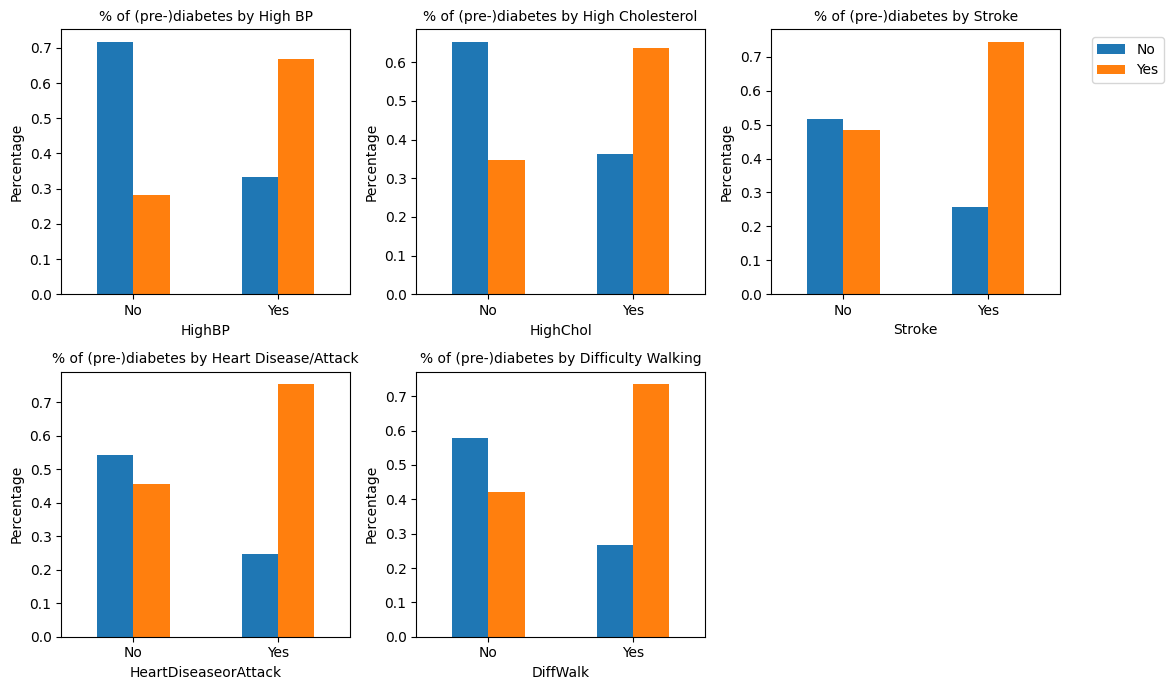

In [19]:
features = ["HighBP", "HighChol", "Stroke", "HeartDiseaseorAttack", "DiffWalk"]
titles = ["High BP", "High Cholesterol", "Stroke", "Heart Disease/Attack", "Difficulty Walking"]
titles = ["% of (pre-)diabetes by " + title for title in titles]
plot_binary(df0, "target", features, titles, grid_shape=(2, 3), figure_size=(12, 7), bounding_box=(0.98, 0.95))

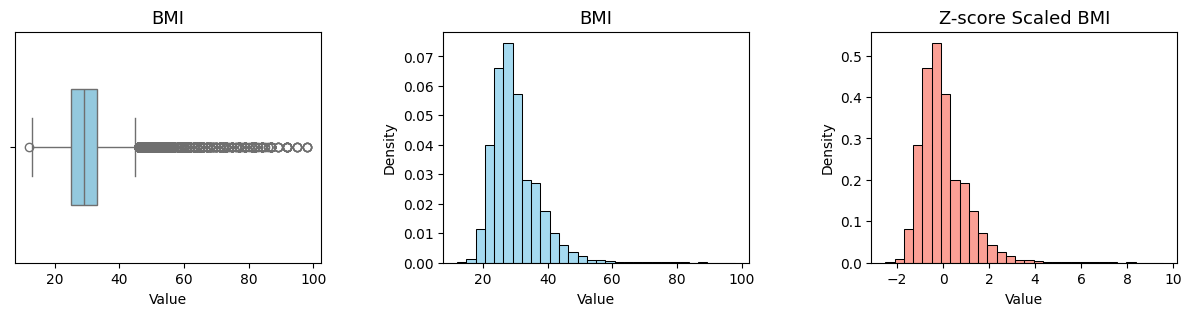

In [11]:
# BMI
scaler = StandardScaler(with_std=True)
df0["BMI_scaled"] = scaler.fit_transform(df0[["BMI"]]).flatten()

plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
sns.boxplot(x ="BMI", data=df0, orient="h", width=0.5, color="skyblue")
plt.xlabel("Value")
plt.ylabel("")
plt.title("BMI", fontsize=13)

plt.subplot(1, 3, 2)
sns.histplot(x="BMI", data=df0, bins=30, kde=False, color="skyblue", stat="density")
plt.xlabel("Value")
plt.title("BMI", fontsize=13)

plt.subplot(1, 3, 3)
sns.histplot(x="BMI_scaled", data=df0, bins=30, kde=False, color="salmon", stat="density")
plt.xlabel("Value")
plt.title("Z-score Scaled BMI", fontsize=13)

plt.subplots_adjust(wspace=0.4)
plt.show()

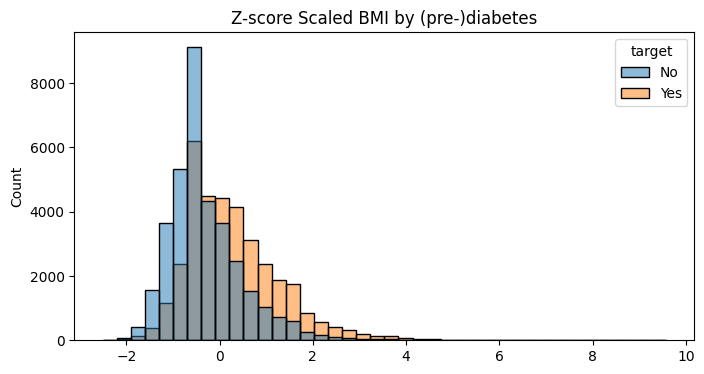

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(x="BMI_scaled", data=df0, hue="target", bins=40)
plt.title("Z-score Scaled BMI by (pre-)diabetes")
plt.xlabel("")
plt.show()

##### Perceived health

* There are 3 variables related to preceived health: `GenHlth`_(ordinal)_, `MentHlth`_(numerical)_, `PhysHlth`_(numerical)_

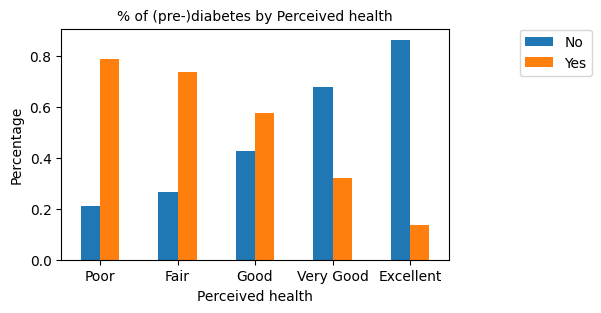

In [13]:
cat_type = pd.CategoricalDtype(categories=order_genhlth, ordered=True)
x = df0["GenHlth"].map(mapping_genhlth).astype(cat_type)

df_crosstab = pd.crosstab(x, df0["target"], dropna=False, normalize="index")
fig, ax = plt.subplots(figsize=(5, 3))
df_crosstab.plot.bar(rot=0, ax=ax)
ax.set_xlabel("Perceived health")
ax.set_ylabel("Percentage")
ax.set_title("% of (pre-)diabetes by Perceived health", fontsize=10)
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.2, 0.9), bbox_transform=plt.gcf().transFigure)
plt.show()

In [14]:
# bins = [-1, 0, 15, 30]
# labels = ["0", "1-15", "16-30"]
# bins = [-1, 0, 10, 20, 30]
# labels = ['0', '1-10', '11-20', '21-30']
bins = [-1, 0, 7, 14, 21, 28, 30]
labels = ['0', '1-7', '8-14', '15-21', '22-28', '29-30']
df0["PhysHlth_group"] = pd.cut(df0["PhysHlth"], bins=bins, labels=labels)
df0["MentHlth_group"] = pd.cut(df0["MentHlth"], bins=bins, labels=labels)

In [15]:
def compare_day_grouping(feature_before_group, feature_after_group, title):
    # Prepare data for first plot
    df_crosstab1 = df0[feature_before_group].value_counts(normalize=True).sort_index() * 100
    df_crosstab1 = df_crosstab1.to_frame().reset_index(drop=False).rename(columns={"proportion": "percentage"})
    df_crosstab1[feature_before_group] = df_crosstab1[feature_before_group].astype("int64")

    # Prepare data for second plot
    df_crosstab2 = df0[feature_after_group].value_counts(normalize=True).sort_index() * 100
    df_crosstab2 = df_crosstab2.to_frame().reset_index(drop=False).rename(columns={"proportion": "percentage"})

    # Create a figure with GridSpec
    fig = plt.figure(figsize=(11, 3))
    gs = fig.add_gridspec(1, 3)

    # Create the first subplot (2/3 of the figure)
    ax1 = fig.add_subplot(gs[0, :2])
    sns.barplot(data=df_crosstab1, x=feature_before_group, y="percentage", ax=ax1)
    ax1.set_title(f"{title} before grouping")
    ax1.set_xlabel("Number of days")

    # Create the second subplot (1/3 of the figure)
    ax2 = fig.add_subplot(gs[0, 2])
    sns.barplot(data=df_crosstab2, x=feature_after_group, y="percentage", ax=ax2)
    ax2.set_title(f"{title} after grouping")
    ax2.set_xlabel("Number of days")

    plt.tight_layout()
    plt.show()

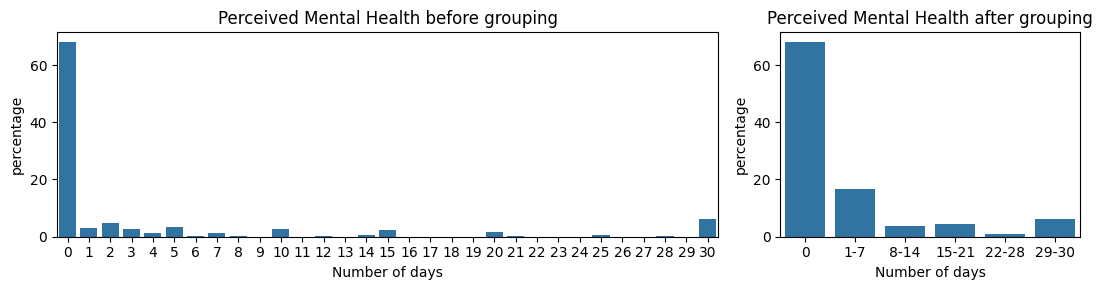

In [16]:
compare_day_grouping("MentHlth", "MentHlth_group", "Perceived Mental Health")

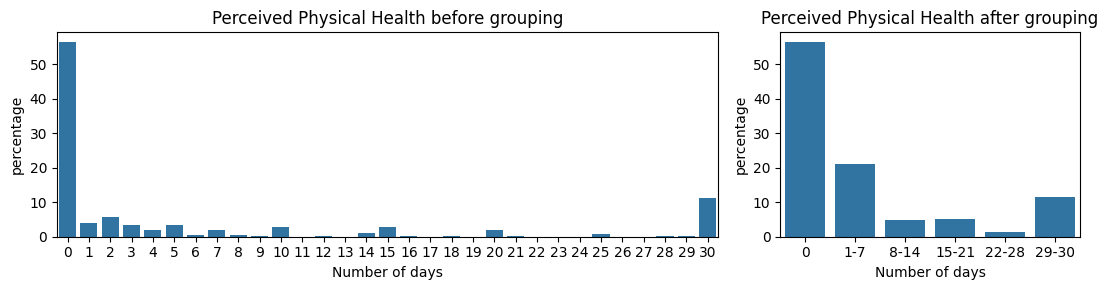

In [17]:
compare_day_grouping("PhysHlth", "PhysHlth_group", "Perceived Physical Health")

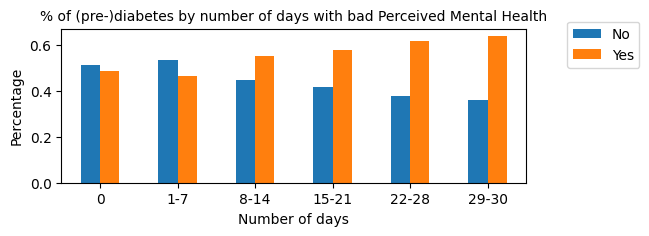

In [18]:
fig, ax = plt.subplots(figsize=(6, 2))
df = pd.crosstab(df0["MentHlth_group"], df0["target"], dropna=False, normalize="index")
ax = df.plot.bar(rot=0,ax=ax)
ax.set_xlabel("Number of days")
ax.set_ylabel("Percentage")
ax.set_title("% of (pre-)diabetes by number of days with bad Perceived Mental Health", fontsize=10)
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.1,0.95), bbox_transform=plt.gcf().transFigure)
plt.show()

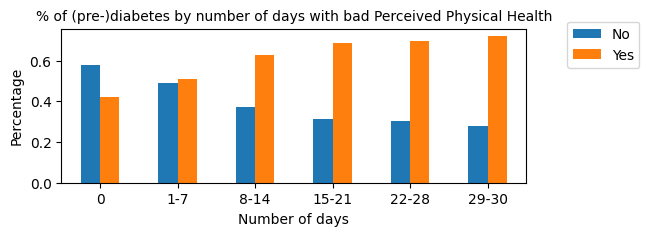

In [19]:
fig, ax = plt.subplots(figsize=(6, 2))
df = pd.crosstab(df0["PhysHlth_group"], df0["target"], dropna=False, normalize="index")
ax = df.plot.bar(rot=0,ax=ax)
ax.set_xlabel("Number of days")
ax.set_ylabel("Percentage")
ax.set_title("% of (pre-)diabetes by number of days with bad Perceived Physical Health", fontsize=10)
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.1,0.95), bbox_transform=plt.gcf().transFigure)
plt.show()

##### Lifestyle

* There are 6 variables related to lifestyle: `CholCheck`_(binary)_, `Smoker`_(binary)_, `PhysActivity`_(binary)_, `Fruits`_(binary)_, `Veggies`_(binary)_, `HvyAlcoholConsump`_(binary)_

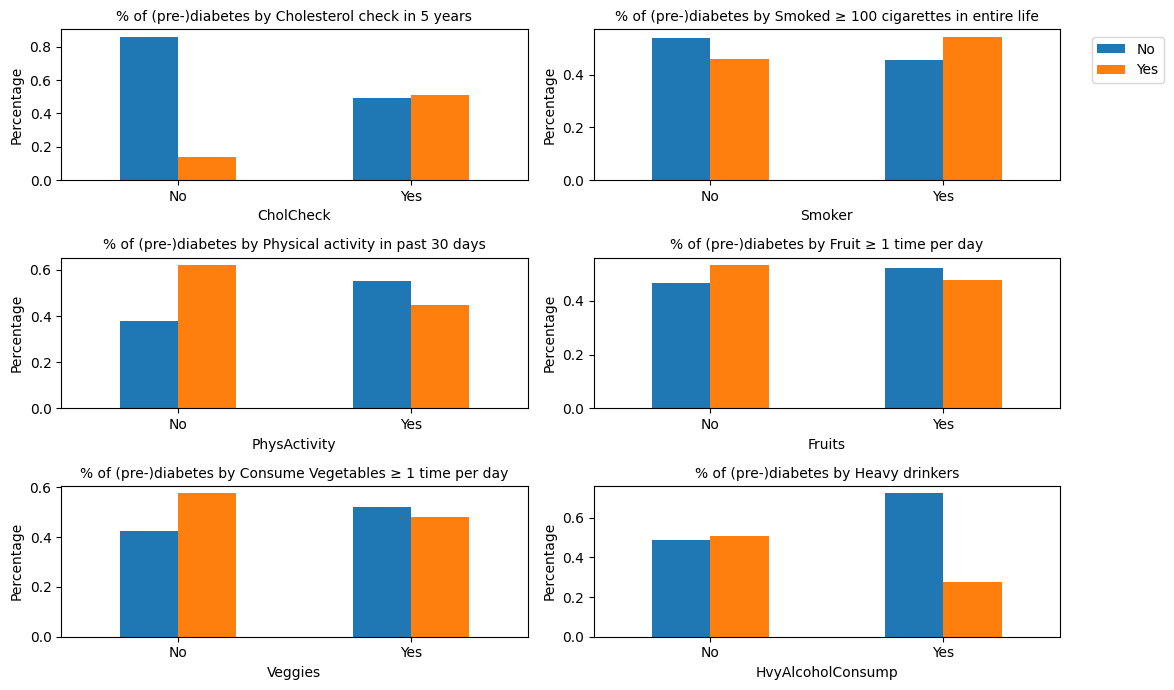

In [20]:
features = ["CholCheck", "Smoker", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump"]
titles = ["Cholesterol check in 5 years", "Smoked ≥ 100 cigarettes in entire life", "Physical activity in past 30 days", "Fruit ≥ 1 time per day", "Consume Vegetables ≥ 1 time per day", "Heavy drinkers"]
titles = ["% of (pre-)diabetes by " + title for title in titles]
plot_binary(df0, "target", features, titles, grid_shape=(3, 2), figure_size=(12, 7), bounding_box=(0.98, 0.95))

##### Financial difficulty

* There are 2 variables related to financial difficulty: `AnyHealthcare`_(binary)_ and `NoDocbcCost`_(binary)_

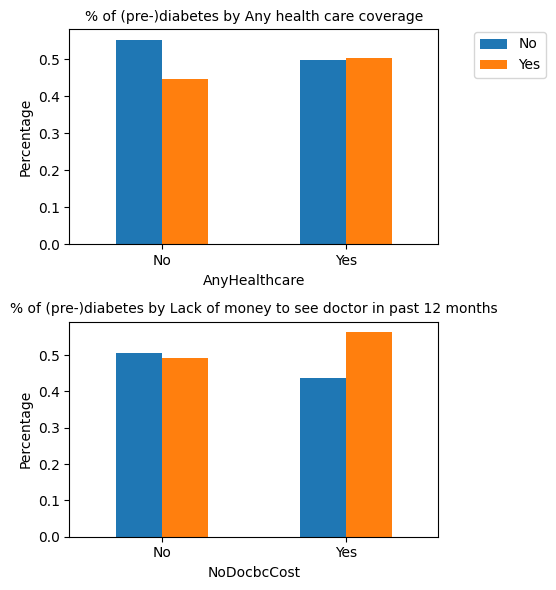

In [21]:
features = ["AnyHealthcare", "NoDocbcCost"]
titles = ["Any health care coverage", "Lack of money to see doctor in past 12 months"]
titles = ["% of (pre-)diabetes by " + title for title in titles]
plot_binary(df0, "target", features, titles, grid_shape=(2, 1), figure_size=(5, 6), bounding_box=(1.1, 0.95))

##### Demographic

* There are 4 demographic variables: `Sex`_(binary)_, `Age`_(ordinal)_, `Education`_(ordinal)_, `Income`_(ordinal)_

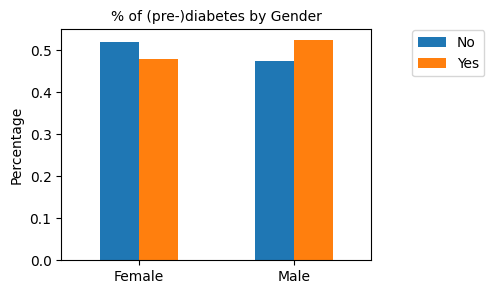

In [22]:
# Sex
df_crosstab = pd.crosstab(df0["Sex"].map(mapping_gender), df0["target"], dropna=False, normalize="index")
fig, ax = plt.subplots(figsize=(4, 3))
df_crosstab.plot.bar(rot=0, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Percentage")
ax.set_title("% of (pre-)diabetes by Gender", fontsize=10)
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.2, 0.9), bbox_transform=plt.gcf().transFigure)
plt.show()

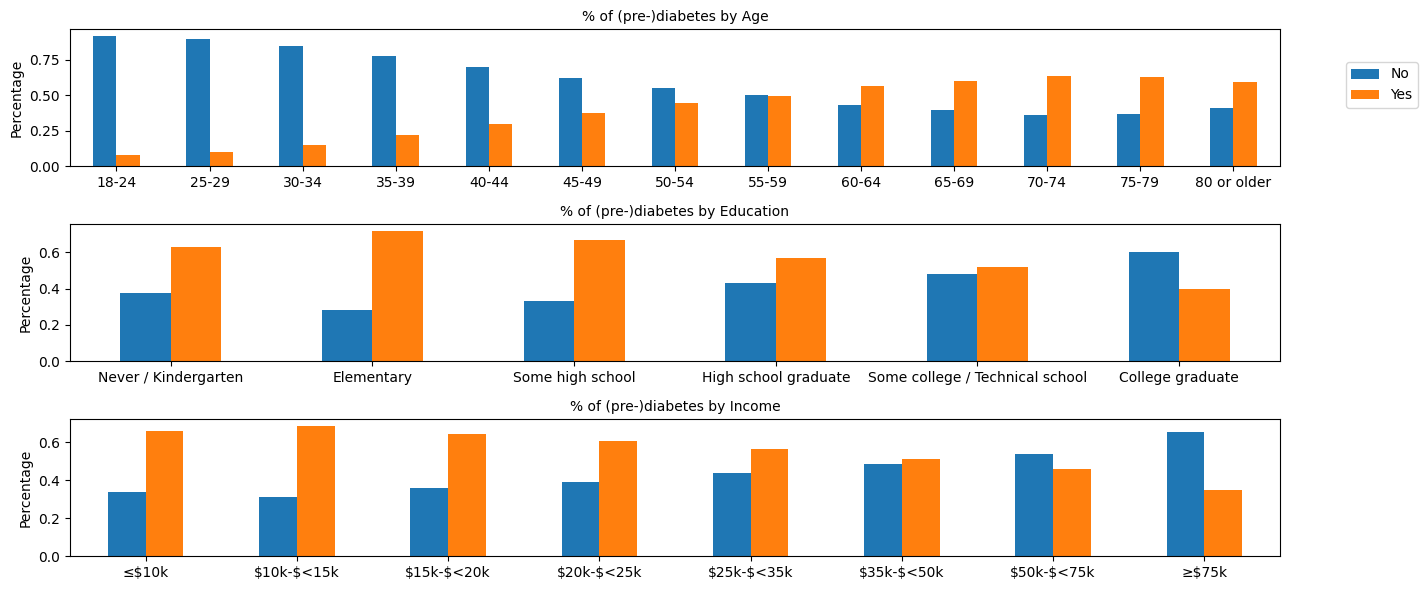

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(13, 6))
axes = axes.flatten()

y = df0["target"]

cat_type = pd.CategoricalDtype(categories=order_age, ordered=True)
x = df0["Age"].map(mapping_age).astype(cat_type)
df_crosstab = pd.crosstab(x, y, dropna=False, normalize="index")
df_crosstab.plot.bar(rot=0, ax=axes[0])
axes[0].set_xlabel("")
axes[0].set_ylabel("Percentage")
axes[0].set_title("% of (pre-)diabetes by Age", fontsize=10)
axes[0].legend().remove()

cat_type = pd.CategoricalDtype(categories=order_edu, ordered=True)
x = df0["Education"].map(mapping_edu).astype(cat_type)
df_crosstab = pd.crosstab(x, y, dropna=False, normalize="index")
df_crosstab.plot.bar(rot=0, ax=axes[1])
axes[1].set_xlabel("")
axes[1].set_ylabel("Percentage")
axes[1].set_title("% of (pre-)diabetes by Education", fontsize=10)
axes[1].legend().remove()

cat_type = pd.CategoricalDtype(categories=order_income, ordered=True)
x = df0["Income"].map(mapping_income).astype(cat_type)
df_crosstab = pd.crosstab(x, y, dropna=False, normalize="index")
df_crosstab.plot.bar(rot=0, ax=axes[2])
axes[2].set_xlabel("")
axes[2].set_ylabel("Percentage")
axes[2].set_title("% of (pre-)diabetes by Income", fontsize=10)
axes[2].legend().remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.1, 0.9), bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.show()

### Data preprocessing

#### Encoding

In [24]:
ordinal_encoder = OrdinalEncoder(categories=[["0", "1-7", "8-14", "15-21", "22-28", "29-30"]])
df0["PhysHlth_encoded"] = ordinal_encoder.fit_transform(df0[["PhysHlth_group"]])
df0["MentHlth_encoded"] = ordinal_encoder.fit_transform(df0[["MentHlth_group"]])

In [25]:
df1 = df0.drop(columns=["target", "BMI", "MentHlth", "PhysHlth", "PhysHlth_group", "MentHlth_group"])

In [26]:
df1.to_excel("./data/df1.xlsx", index=False)

#### Data partition

In [27]:
X = df1.iloc[:, 1:].values
y = df1.iloc[:,0].values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model building

#### Baseline model

In [29]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", metrics=["accuracy"], 
optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-08))

In [30]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [31]:
training_accuracy = history.history["accuracy"][-1] * 100
validation_accuracy = history.history["val_accuracy"][-1] * 100
print(f"Training accuracy: {round(training_accuracy, 2)}")
print(f"Validation accuracy: {round(validation_accuracy, 2)}")

Training accuracy: 77.05
Validation accuracy: 74.37


* Although we did not know Bayes error, let's try if the training accuracy can be improved

### Model selection / tuning

##### Reduce avoidable bias
* To reduce the gap between Bayes error and training error, a bigger network is fitted

In [32]:
def build_model(hp): 
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for i in range(hp.Int("num_layers", 2, 4)):
        model.add(Dense(hp.Int(f"units_{i}", min_value=32, max_value=128, step=32), activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], 
optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-08))
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="hide/training history",
    project_name="train bigger model_v1"
)

Reloading Tuner from hide/train bigger model_v2/tuner0.json


In [34]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}


In [35]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

In [36]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The best NN architecture: {best_hp.values}")

The best NN architecture: {'num_layers': 3, 'units_0': 128, 'units_1': 128, 'units_2': 32}


In [37]:
tuner.results_summary(1)

Results summary
Results in hide/train bigger model_v2
Showing 1 best trials
Objective(name="accuracy", direction="max")

Trial 00 summary
Hyperparameters:
num_layers: 3
units_0: 128
units_1: 128
units_2: 32
Score: 0.7895981669425964


In [38]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
training_accuracy = best_trial.metrics.get_history("accuracy")
validation_accuracy = best_trial.metrics.get_history("val_accuracy")
training_accuracy = [metric.value for metric in training_accuracy][0][0]
validation_accuracy = [metric.value for metric in validation_accuracy][0][0]

In [39]:
print(f"Training accuracy: {round(training_accuracy*100, 2)}")
print(f"Validation accuracy: {round(validation_accuracy*100, 2)}")

Training accuracy: 78.96
Validation accuracy: 73.42


* The training accuracy only improves slightly

##### Reduce variance
* To reduce variance, L2 regularisation was added

In [40]:
def build_model(hp): 
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    model.add(Dense(128, activation="relu", kernel_regularizer=l2(hp.Float("l2_0", min_value=1e-5, max_value=1e-2, sampling="LOG"))))
    model.add(Dense(128, activation="relu", kernel_regularizer=l2(hp.Float("l2_1", min_value=1e-5, max_value=1e-2, sampling="LOG"))))
    model.add(Dense(32, activation="relu", kernel_regularizer=l2(hp.Float("l2_2", min_value=1e-5, max_value=1e-2, sampling="LOG"))))

    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], 
optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-08))
    return model

In [41]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="hide",
    project_name="l2_tuning_v1"
)

Reloading Tuner from hide/l2_tuning_v1/tuner0.json


In [42]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
l2_0 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
l2_1 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
l2_2 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [43]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

In [44]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hp.values)

{'l2_0': 1.7712345526835492e-05, 'l2_1': 5.101462250647536e-05, 'l2_2': 0.003332283580166981}


In [45]:
tuner.results_summary(1)

Results summary
Results in hide/l2_tuning_v1
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
l2_0: 1.7712345526835492e-05
l2_1: 5.101462250647536e-05
l2_2: 0.003332283580166981
Score: 0.7536026835441589


In [46]:
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
training_accuracy = best_trial.metrics.get_history("accuracy")
validation_accuracy = best_trial.metrics.get_history("val_accuracy")
training_accuracy = [metric.value for metric in training_accuracy][0][0]
validation_accuracy = [metric.value for metric in validation_accuracy][0][0]

In [47]:
print(f"Training accuracy: {round(training_accuracy*100, 2)}")
print(f"Validation accuracy: {round(validation_accuracy*100, 2)}")

Training accuracy: 75.21
Validation accuracy: 75.36


* The validation accuracy improved from 73.42% to 75.36%

### Model evaluation

In [48]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/Users/wilson/Documents/Python/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,489 (91.75 KB)

 Trainable params: 23,489 (91.75 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.7553 - loss: 0.5016


print(f"Test accuracy: {round(test_accuracy*100, 2)}")

### Model interpretation

In [67]:
def score_func(y_true, y_pred):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int))
def permutation_importance_custom(model, X, y, n_repeats=30, random_state=42):
    rng = np.random.default_rng(random_state)
    n_samples, n_features = X.shape
    base_score = score_func(y, model.predict(X, verbose=0))
    scores = np.zeros((n_repeats, n_features))
    
    for i in range(n_features):
        for j in range(n_repeats):
            X_permuted = X.copy()
            perm_idx = rng.permutation(n_samples)
            X_permuted[:, i] = X_permuted[perm_idx, i]
            shuffled_score = score_func(y, model.predict(X_permuted, verbose=0))
            scores[j, i] = base_score - shuffled_score
            
    importances_mean = scores.mean(axis=0)
    importances_std = scores.std(axis=0)
    
    return importances_mean, importances_std

In [68]:
importances_mean, importances_std = permutation_importance_custom(best_model, X_test, y_test)
feature_names = list(df1.columns)[1:]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_mean,
    'Std': importances_std
})

In [69]:
importance_df = importance_df.sort_values('Importance', ascending=False)

In [70]:
print("Feature Importance Scores:")
print("-------------------------")
for idx, row in importance_df.iterrows():
    if row['Importance'] - 2 * row['Std'] > 0:  # Only show significant features
        print(f"{row['Feature']:<20} {row['Importance']:.4f} ± {row['Std']:.4f}")

Feature Importance Scores:
-------------------------
GenHlth              0.0451 ± 0.0021
BMI_scaled           0.0362 ± 0.0021
Age                  0.0217 ± 0.0018
HighBP               0.0168 ± 0.0019
HighChol             0.0093 ± 0.0012
Income               0.0031 ± 0.0011
HvyAlcoholConsump    0.0031 ± 0.0008


<Figure size 1000x1200 with 0 Axes>

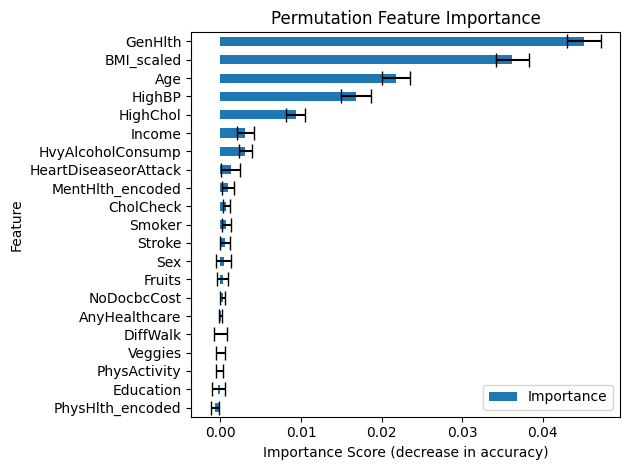

In [71]:
# Create a horizontal bar plot for better readability
plt.figure(figsize=(10, 12))
importance_df_reversed = importance_df.sort_values('Importance', ascending=True)
importance_df_reversed.plot(kind='barh', x='Feature', y='Importance', xerr='Std', capsize=5)
plt.xlabel('Importance Score (decrease in accuracy)')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

* The permutation importance shows that permuting a feature drops the accuracy by at most 0.04. This would suggest that none of the features are important. This contradicts the high test accuracy which means some features must be important
* [The documentation of scikit-learn](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html) suggests to perform hierarchical clustering on the Spearman rank-order correlations and keep a single feature from each cluster. However, most variables are binary. [It is not meaningful to calculate the correlation between binary variables](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). 
* SHAP also suffers from the problem of feature dependence. This is because [the calculation of Shapley values has problems when there are correlated features](https://www.linkedin.com/pulse/shapley-value-advantages-disadvantages-yaser-gholizade-fcwqe). 
* Possible solutions:
    1. [Kaneko (2022) proposed cross-validated permutation feature importance](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/ansa.202200018) to overcome this problem
    2. Select features before modeling 
    3. Combine features with techniques such as domain knowledge or Principal Components Analysis